In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score, roc_auc_score, roc_curve, auc ,precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:

BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 20
n_classes = 8

# Preprocessing and Loading Dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Hasibul/Variant-a(Multiclass Classification)",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4525 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['test', 'train', 'val']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[2 1 1 1 2 1 1 1 0 0 1 0 1 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1]


# Train Datasets

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Hasibul/Variant-a(Multiclass Classification)/train",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3162 files belonging to 8 classes.


# Test Datasets

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Hasibul/Variant-a(Multiclass Classification)/test",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 461 files belonging to 8 classes.


# Vaid datasets

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Hasibul/Variant-a(Multiclass Classification)/val",
    seed=1234,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 902 files belonging to 8 classes.


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)


# Data Augmentations

In [ ]:
# Create data augmentation layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Models Merging

In [ ]:

vgg19_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Make some layers trainable in VGG19
for layer in vgg19_model.layers[-12:]:
    layer.trainable = True


inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Make some layers trainable in InceptionV3
for layer in inception_model.layers[-20:]:
    layer.trainable = True


input_layer = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = resize_and_rescale(input_layer)
x = data_augmentation(x)

vgg19_output = vgg19_model(x)

inception_output = inception_model(x)


vgg19_output = layers.GlobalAveragePooling2D()(vgg19_output)
inception_output = layers.GlobalAveragePooling2D()(inception_output)


concatenated = layers.Concatenate()([vgg19_output, inception_output])

dense1 = layers.Dense(512, activation='relu')(concatenated)
dropout1 = layers.Dropout(0.5)(dense1)

output_layer = layers.Dense(8, activation='softmax')(dropout1)

model = models.Model(inputs=input_layer, outputs=output_layer)

# Model Summary

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 224, 224, 3)          0         ['input_9[0][0]']             
                                                                                                  
 sequential_5 (Sequential)   (None, 224, 224, 3)          0         ['sequential_4[0][0]']        
                                                                                                  
 vgg19 (Functional)          (None, 7, 7, 512)            2002438   ['sequential_5[0][0]']        
                                                          4                                 

# Compiling Model

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


# Model Training

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=20,
    callbacks=[lr_schedule]
)

Epoch 1/20
99/99 [==============================] - 125s 850ms/step - loss: 1.3683 - accuracy: 0.5244 - val_loss: 1.0341 - val_accuracy: 0.6441 - lr: 1.0000e-04
Epoch 2/20
99/99 [==============================] - 79s 804ms/step - loss: 0.8579 - accuracy: 0.6920 - val_loss: 0.9116 - val_accuracy: 0.6996 - lr: 1.0000e-04
Epoch 3/20
99/99 [==============================] - 83s 841ms/step - loss: 0.6618 - accuracy: 0.7593 - val_loss: 0.6869 - val_accuracy: 0.7650 - lr: 1.0000e-04
Epoch 4/20
99/99 [==============================] - 79s 801ms/step - loss: 0.5131 - accuracy: 0.8213 - val_loss: 0.7093 - val_accuracy: 0.7605 - lr: 1.0000e-04
Epoch 5/20
99/99 [==============================] - 79s 800ms/step - loss: 0.4314 - accuracy: 0.8428 - val_loss: 0.8161 - val_accuracy: 0.7672 - lr: 1.0000e-04
Epoch 6/20
99/99 [==============================] - 79s 799ms/step - loss: 0.3610 - accuracy: 0.8763 - val_loss: 0.5416 - val_accuracy: 0.8237 - lr: 9.0484e-05
Epoch 7/20
99/99 [=====================

# Model History

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 99}

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

# Model Accuracy for first 5 Epochs

In [ ]:
history.history['accuracy'][:5] # show loss for first 5 epochs

[0.5243516564369202,
 0.6919671297073364,
 0.7593295574188232,
 0.8213156461715698,
 0.8428210020065308]

# Table Representation of Model Epochs

In [ ]:
import pandas as pd
from tabulate import tabulate

# Assuming history is a dictionary with relevant metrics
history_metrics = {
    'Epoch': range(1, 19),  # Assuming you want the first 7 epochs
    'Val_Loss': history.history['val_loss'][:18],
    'Val_Accuracy': history.history['val_accuracy'][:18],
    'Loss': history.history['loss'][:18],
    'Accuracy': history.history['accuracy'][:18]
}

# Creating a DataFrame
df = pd.DataFrame(history_metrics)

# Limiting decimal places to two
df = df.round(2)

df.to_csv('history_metrics.csv', index=False)

# Displaying the DataFrame in a tabulated format
table = tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False)

print(table)


╒═════════╤════════════╤════════════════╤════════╤════════════╕
│   Epoch │   Val_Loss │   Val_Accuracy │   Loss │   Accuracy │
╞═════════╪════════════╪════════════════╪════════╪════════════╡
│       1 │       1.03 │           0.64 │   1.37 │       0.52 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       2 │       0.91 │           0.7  │   0.86 │       0.69 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       3 │       0.69 │           0.76 │   0.66 │       0.76 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       4 │       0.71 │           0.76 │   0.51 │       0.82 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       5 │       0.82 │           0.77 │   0.43 │       0.84 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       6 │       0.54 │           0.82 │   0.36 │       0.88 │
├─────────┼────────────┼────────────────┼────────┼────────────┤
│       7 │       0.47 │           0.84 

# Training and Validation Loss & Accuracy

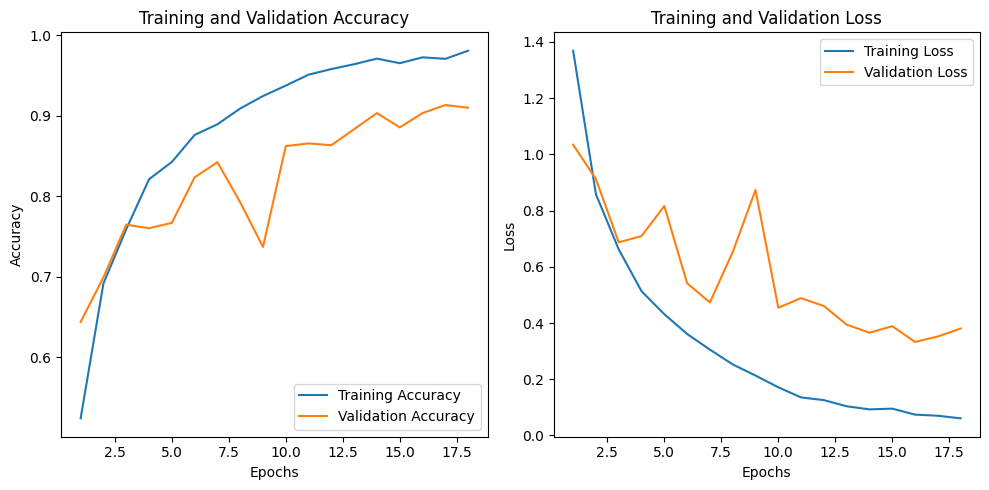

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy'][:18]
val_acc = history.history['val_accuracy'][:18]
loss = history.history['loss'][:18]
val_loss = history.history['val_loss'][:18]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot position 1
plt.plot(range(1, 19), acc, label='Training Accuracy')
plt.plot(range(1, 19), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot position 2
plt.plot(range(1, 19), loss, label='Training Loss')
plt.plot(range(1, 19), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.savefig('training_plot.png')

plt.tight_layout()  # To adjust the spacing between subplots
plt.show()


# Model Performace

In [ ]:
model.evaluate(test_ds)

15/15 [==============================] - 4s 213ms/step - loss: 0.3091 - accuracy: 0.9111


[0.3091139793395996, 0.9110628962516785]

In [ ]:
class_names = ['Early_blight', 'Healthy', 'Late_blight','Leaf Miner','Magnesium Deficiency','Nitrogen Deficiency','Pottassium Deficiency','Spotted Wilt Virus']  # Make sure it matches your dataset


# Predicting from Test Dataset

first image to predict
actual label: Healthy
1/1 [==============================] - 1s 1s/step
predicted label: Magnesium Deficiency


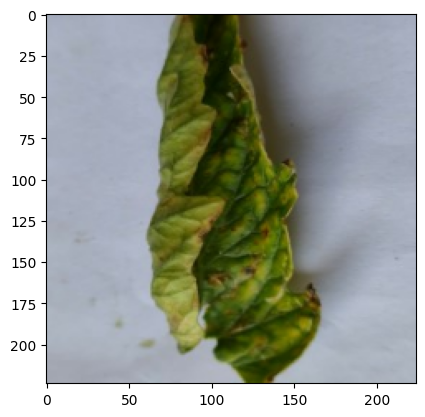

In [ ]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the prediction is within the valid range
    predicted_index = np.argmax(batch_prediction[0])
    if 0 <= predicted_index < len(class_names):
        print("predicted label:", class_names[predicted_index])
    else:
        print("Invalid predicted index:", predicted_index)




first image to predict
actual label: Spotted Wilt Virus
1/1 [==============================] - 0s 36ms/step
predicted label: Spotted Wilt Virus


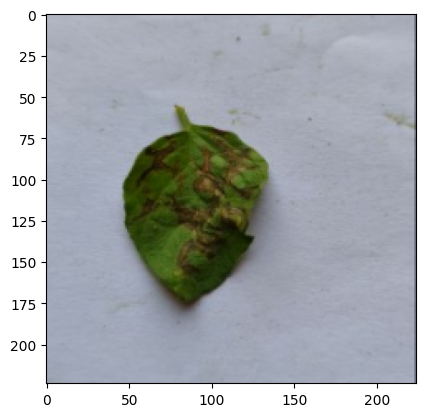

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Predicted and Actual Labels

first image to predict
actual label: Healthy
1/1 [==============================] - 0s 38ms/step
predicted label 1: Early_blight
predicted label 2: Magnesium Deficiency
predicted label 3: Leaf Miner
predicted label 4: Magnesium Deficiency
predicted label 5: Early_blight
predicted label 6: Leaf Miner
predicted label 7: Late_blight
predicted label 8: Nitrogen Deficiency
predicted label 9: Leaf Miner
predicted label 10: Pottassium Deficiency
predicted label 11: Leaf Miner
predicted label 12: Leaf Miner
predicted label 13: Early_blight
predicted label 14: Healthy
predicted label 15: Nitrogen Deficiency
predicted label 16: Leaf Miner
predicted label 17: Early_blight
predicted label 18: Magnesium Deficiency
predicted label 19: Pottassium Deficiency
predicted label 20: Nitrogen Deficiency
predicted label 21: Leaf Miner
predicted label 22: Magnesium Deficiency
predicted label 23: Leaf Miner
predicted label 24: Nitrogen Deficiency
predicted label 25: Late_blight
predicted label 26: Spotted Wilt

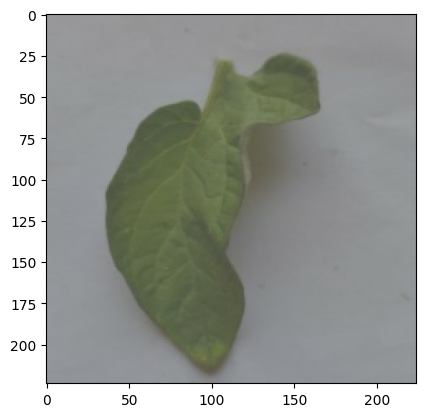

In [ ]:
# Example usage of class_names
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    # Ensure that the actual label is within the valid range
    if 0 <= first_label < len(class_names):
        print("actual label:", class_names[first_label])
    else:
        print("Invalid actual label value:", first_label)

    batch_prediction = model.predict(images_batch)

    # Ensure that the predicted labels are within the valid range
    y_pred_indices = np.argmax(batch_prediction, axis=1)
    for i in range(len(y_pred_indices)):
        if 0 <= y_pred_indices[i] < len(class_names):
            print(f"predicted label {i + 1}:", class_names[y_pred_indices[i]])
        else:
            print(f"Invalid predicted index {i + 1}:", y_pred_indices[i])




In [ ]:
predicted_labels = []
actual_labels = []

for images, labels in test_ds:
    # Predict class for each image in the batch
    y_pred = model.predict(images)
    y_pred = np.argmax(y_pred, axis=1)

    # Append predicted and actual class labels to lists
    for i in range(len(labels)):
        predicted_labels.append(class_names[y_pred[i]])
        actual_labels.append(class_names[labels[i]])

plt.show()

1/1 [==============================] - 0s 35ms/step


# Confusion Matrix

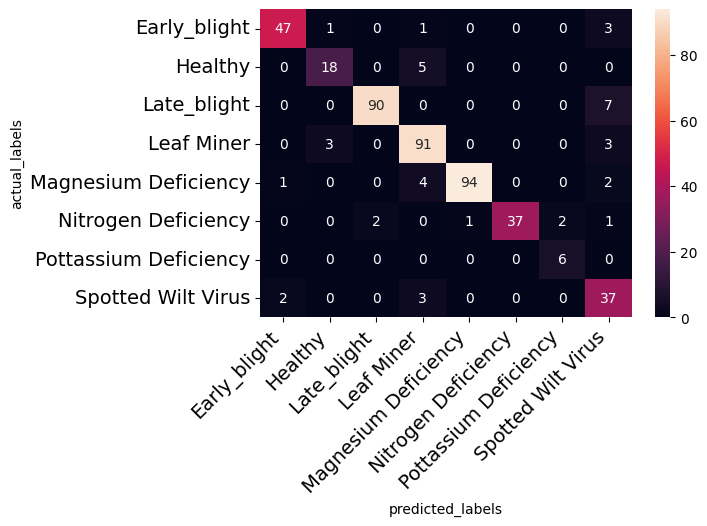

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('actual_labels')
    plt.xlabel('predicted_labels')
    plt.savefig('confusion.png')

cm = confusion_matrix(predicted_labels,actual_labels)
print_confusion_matrix(cm,['Early_blight', 'Healthy', 'Late_blight','Leaf Miner','Magnesium Deficiency','Nitrogen Deficiency','Pottassium Deficiency','Spotted Wilt Virus'])

In [ ]:
# Ensure that the length of both lists is the same
if len(predicted_labels) == len(actual_labels):
    correct_predictions = sum(p == a for p, a in zip(predicted_labels, actual_labels))
    total_predictions = len(predicted_labels)

    accuracy = correct_predictions / total_predictions * 100
    print(f"Accuracy: {accuracy:.2f}%")
else:
    print("Error: The number of elements in predicted_labels and actual_labels must be the same.")

Accuracy: 91.11%


# Precision,Recall, F1 Score

In [ ]:
# Calculating Precision-Recall-F1
# You can use 'macro', 'weighted', or 'micro' as per your requirement

if len(predicted_labels) == len(actual_labels):
    # Calculate F1 score for multi-class classification

    precision = precision_score(actual_labels, predicted_labels, average='weighted')
    print(f"precision_score: {precision:.2f}")
    recall = recall_score(actual_labels, predicted_labels, average='weighted')
    print(f"Recall Score: {recall:.2f}")
    f1 = f1_score(actual_labels, predicted_labels, average='weighted')
    print(f"F1 Score: {f1:.2f}")

else:
    print("Error: The number of elements in predicted_labels and actual_labels must be the same.")

precision_score: 0.91
Recall Score: 0.91
F1 Score: 0.91


# ROC Curve

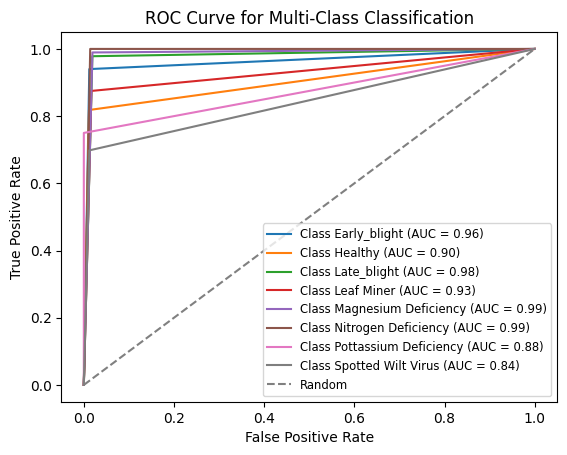

In [ ]:
# Convert class labels to binary matrix (one-hot encoding)
label_binarizer = LabelBinarizer()
actual_binary = label_binarizer.fit_transform(actual_labels)
predicted_binary = label_binarizer.transform(predicted_labels)

# Compute ROC AUC for each class
auc_scores = []
for i in range(len(label_binarizer.classes_)):
    auc = roc_auc_score(actual_binary[:, i], predicted_binary[:, i])
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(actual_binary[:, i], predicted_binary[:, i])
    plt.plot(fpr, tpr, label=f"Class {label_binarizer.classes_[i]} (AUC = {auc:.2f})")

# Plot ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')

# Set the legend fontsize to a smaller value
plt.legend(fontsize='small')
plt.savefig('ROC.png')

plt.show()


# Average AUC

In [ ]:
# Create a DataFrame with class names and corresponding AUC scores
auc_table = pd.DataFrame({'Class': class_names, 'AUC Score': auc_scores})

# Print the table
print(auc_table)

# Average AUC across all classes
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc:.2f}")

                   Class  AUC Score
0           Early_blight   0.963917
1                Healthy   0.903396
2            Late_blight   0.979645
3             Leaf Miner   0.929097
4   Magnesium Deficiency   0.985174
5    Nitrogen Deficiency   0.992925
6  Pottassium Deficiency   0.875000
7     Spotted Wilt Virus   0.842929
Average AUC: 0.93


In [ ]:
print(classification_report(actual_labels, predicted_labels))

                       precision    recall  f1-score   support

         Early_blight       0.90      0.94      0.92        50
              Healthy       0.78      0.82      0.80        22
          Late_blight       0.93      0.98      0.95        92
           Leaf Miner       0.94      0.88      0.91       104
 Magnesium Deficiency       0.93      0.99      0.96        95
  Nitrogen Deficiency       0.86      1.00      0.92        37
Pottassium Deficiency       1.00      0.75      0.86         8
   Spotted Wilt Virus       0.88      0.70      0.78        53

             accuracy                           0.91       461
            macro avg       0.90      0.88      0.89       461
         weighted avg       0.91      0.91      0.91       461



In [ ]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(test_ds)[1]
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

15/15 [==============================] - 3s 214ms/step - loss: 0.3091 - accuracy: 0.9111
Test Accuracy: 91.11%


# Save Model

In [ ]:
model.save('Hasib_Tomato.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
